## Bootstrapping an OIS curve

In this notebook we will try to bootstrap an OIS curve to satisfy the minimal requirement of ISDA-SIMM. By exactly matching
the minimal requirement we do not introduce any added complexity that wouldn't increase the granularity of the risk model
anyways.

ISDA-SIMM has two requirements.
1. We need par Sensitivities  - i.e. the quotes used for bootstrapping the curve need to be shifted and the curve
re-bootstrapped to calculate sensitivities.

2. The minimal tenors for which we need sensitivities are 2W, 1M, 3M, 6M, 1Y, 2Y, 3Y, 5Y, 10Y, 15Y, 20Y and 30Y

Therefore we will bootstrap a curve using 11 swaps on exactly these vertexes.

Our dummy quotes are the following:

In [1]:
import QuantLib as ql

today = ql.Date(10, ql.May, 2019)
ql.Settings.instance().evaluationDate = today

swap_quotes = {(2, ql.Weeks): ql.SimpleQuote(-0.36503/100),
               (1, ql.Months): ql.SimpleQuote(-0.3650/100),
               (3, ql.Months): ql.SimpleQuote(-0.36521/100),
               (6, ql.Months): ql.SimpleQuote(-0.36754/100),
               (1, ql.Years): ql.SimpleQuote(-0.37488/100),
               (3, ql.Years): ql.SimpleQuote(-0.31511/100),
               (10, ql.Years): ql.SimpleQuote(0.28879/100),
               (15, ql.Years): ql.SimpleQuote(0.62908/100),
               (20, ql.Years): ql.SimpleQuote(0.82255/100),
               (30, ql.Years): ql.SimpleQuote(0.92238/100)}

Next we need to create the swaps that are using these quotes. We will collect them in a helper array.

In [2]:
helpers = []

for tenor, quote in swap_quotes.items():
    helpers.append(ql.OISRateHelper(0, ql.Period(*tenor), ql.QuoteHandle(quote), ql.Eonia()))

In [3]:
eonia_curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), helpers, ql.Actual360())

eonia_curve.enableExtrapolation()

In [4]:
end= today+ql.Period(30, ql.Years)
dates= [ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1)]
rates = [eonia_curve.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate() for d in dates]
zero_rates = [eonia_curve.zeroRate(d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple).rate() for d in dates]


TypeError: Wrong number or type of arguments for overloaded function 'YieldTermStructure_zeroRate'.
  Possible C/C++ prototypes are:
    YieldTermStructure::zeroRate(Date const &,DayCounter const &,Compounding,Frequency,bool) const
    YieldTermStructure::zeroRate(Date const &,DayCounter const &,Compounding,Frequency) const
    YieldTermStructure::zeroRate(Date const &,DayCounter const &,Compounding) const
    YieldTermStructure::zeroRate(Time,Compounding,Frequency,bool) const
    YieldTermStructure::zeroRate(Time,Compounding,Frequency) const
    YieldTermStructure::zeroRate(Time,Compounding) const


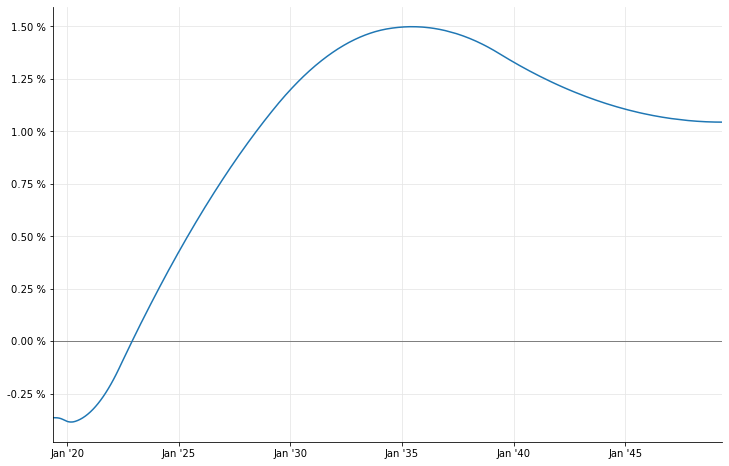

In [26]:
from quantlibpythoncookbook_extras import utils

_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(rates, '-')], format_rates=True)

In [28]:
forwardDate = today + ql.Period(1, ql.Years)
zeroRate = eonia_curve.zeroRate(forwardDate, ql.Actual360(), ql.Simple)
zeroRate.rate

<bound method InterestRate.rate of <QuantLib.QuantLib.InterestRate; proxy of <Swig Object of type 'InterestRate *' at 0x0000012C658C9990> >>

Let's try to perform a roundtrip pricing.

In [80]:
reference_swap = helpers[4].swap()
reference_fixed_leg = reference_swap.fixedLeg()
print(reference_fixed_leg[0].date())
reference_overnight_leg = reference_swap.overnightLeg()
print(reference_overnight_leg[0].date())
testType = reference_swap.type()
reference_swap.pricingEngine()

May 11th, 2020
May 11th, 2020


AttributeError: 'OvernightIndexedSwap' object has no attribute 'pricingEngine'

In [76]:
nominal = 100.0
fixedRate = 0.01
index = ql.Eonia()
dc = ql.Actual360()
type = ql.OvernightIndexedSwap.Receiver

test_schedule1 = ql.Schedule (today, ql.Date(11, ql.May, 2020), ql.Period(1, ql.Days), ql.TARGET(), ql.ModifiedFollowing, ql.ModifiedFollowing, ql.DateGeneration.Forward, False)

test_ois = ql.OvernightIndexedSwap(type, nominal, test_schedule1, fixedRate, dc, index)

Getting a yield curve out of it:

In [84]:
eonia_curve.discount(today)

1.0

In [ ]:
pricingEngine = ql.DiscountingSwapEngine(eonia_curve.discount(today))

In [64]:
test2 = ql.OvernightIndexedSwap.Receiver
sched = ql.Schedule([ql.Date(11, ql.May, 2020)])
test_

